In [230]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像时负号‘-’显示为方块的问题

In [237]:
app = pd.read_csv(r'..\数据\application_record.csv')
cre = pd.read_csv(r'..\数据\credit_record.csv')

In [94]:
len(app)

438557

In [95]:
app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [238]:
# 去除重复ID
app.drop_duplicates(subset='ID',inplace=True)

#### 分类变量诊断

In [160]:
def classify_fun(data = app):
    dic = {'CODE_GENDER':'性别','FLAG_OWN_CAR':'是否有车','FLAG_OWN_REALTY':'是否有房产','NAME_INCOME_TYPE':'收入类型','NAME_EDUCATION_TYPE':'教育程度','NAME_FAMILY_STATUS':'婚姻状态',
           'NAME_HOUSING_TYPE':'居住方式','FLAG_MOBIL':'是否有手机','FLAG_WORK_PHONE':'是否有工作电话','FLAG_PHONE':'是否有电话','FLAG_EMAIL':'是否有邮件','OCCUPATION_TYPE':'职业'}
    name_dic = {'F':'女','M':'男','Y':'是','N':'否','1':'是','0':'否'}
    
    writer = pd.ExcelWriter('分类变量诊断统计2.xlsx')
    row = 0
    for key in dic:
        df = pd.DataFrame(columns=['变量','分类取值','总样本数','分类样本数','分类占比','备注'])
        
        df['分类取值'] = app[key].value_counts().rename(index=name_dic).index # 映射分类取值name_dic字典
        df['分类样本数'] = app[key].value_counts().values
        if len(app[app[key].isna()])>0 : # 缺失值判断
            df = df.append([{'分类取值':'缺失','分类样本数':app[key].isna().agg(sum)}])
        df['总样本数'] = 438510
        df['分类占比'] = (df['分类样本数']/df['总样本数']).apply(lambda x:format(x,'.2%'))
        df['变量'] = dic[key]
        
        df.to_excel(writer,startrow=row,index=False) # 保持到excel
        row = row + len(df) + 2
    writer.save()

In [161]:
classify_fun()

In [129]:
# 职业的一个缺失值改为Unknow
app.loc[app['OCCUPATION_TYPE'].isna(),'OCCUPATION_TYPE'] = 'Unknow'

#### 连续变量诊断统计

In [239]:
app['AGE'] = (-app['DAYS_BIRTH']/365).apply(lambda x: round(x))
app['WORK_TIME'] = (-app['DAYS_EMPLOYED']/365).apply(lambda x: round(x))

In [186]:
def continu_fun():
    dic = {'AMT_INCOME_TOTAL':'年收入','CNT_CHILDREN':'孩子个数','CNT_FAM_MEMBERS':'家庭人数','AGE':'年龄','WORK_TIME':'工作年限'}
    columns_dic = {'count':'总样本数', 'mean':'均值', 'std':'标准差', 'min':'最小值', '50%':'中位数', 'max':'最大值'}
    
    # 已知没有缺失值，故没有设置
    df = pd.DataFrame()
    for key in dic:
        a = (app[key].describe(percentiles=[.5])).apply(lambda x:round(x))
        df = df.append(a)
    df.rename(columns = columns_dic,index=dic,inplace=True)
    df.index.name = '变量'
    df.to_excel('连续变量诊断统计2.xlsx')

In [174]:
continu_fun()

In [243]:
len(app[app['DAYS_EMPLOYED']==365243])

75324

In [242]:
pd.DataFrame(app[app.WORK_TIME>=0].WORK_TIME.describe(percentiles=[.5]))

,WORK_TIME
count,363186.000000
mean,7.196533
std,6.585014
min,0.000000
50%,5.000000
max,48.000000


In [ ]:
app.loc[app['DAYS_EMPLOYED']==365243,'DAYS_EMPLOYED'] = '失业'

#### cre变量诊断

In [203]:
# 没有缺失值

In [199]:
status = pd.DataFrame(cre['STATUS'].value_counts())
status

,STATUS
C,6398779
0,5430795
X,3247736
1,160932
5,22066
2,10664
3,3696
4,2440


In [220]:
a = cre.groupby(['ID'])['MONTHS_BALANCE'].agg(min).value_counts()

Text(0, 0.5, '开户数量')

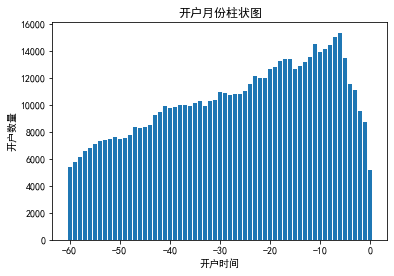

In [248]:
# plt.figure(dpi=300)
plt.bar(a.index,a.values);plt.title('开户月份柱状图')
plt.xlabel('开户时间');plt.ylabel('开户数量')

#### 变量关联诊断-孩子人数>=家庭人数

In [244]:
# 去掉孩子人数>=家庭人数的
app = app[app['CNT_CHILDREN']<app['CNT_FAM_MEMBERS']]

#### 表关联诊断

In [245]:
len(app[~app['ID'].isin(cre['ID'])]) # 只在app

13229

In [246]:
len(cre[~cre['ID'].isin(app['ID'])].drop_duplicates(subset='ID')) # 只在cre出现

204305

In [247]:
len(cre[cre['ID'].isin(app['ID'])].drop_duplicates(subset='ID')) # 共同出现

425182

In [250]:
len(cre.drop_duplicates(subset='ID')) - len(cre[cre['ID'].isin(app['ID'])].drop_duplicates(subset='ID')) # cre删除了多少条信息

204305